# MICROnet Training - Comprehensive Model Comparison

This notebook trains 10 different microstructure prediction models:

## CNN-LSTM Models:
1. CNN-LSTM seq=3, MSE loss
2. CNN-LSTM seq=4, MSE loss
3. CNN-LSTM seq=4, Combined loss (T_solidus=1560, T_liquidus=1620)
4. CNN-LSTM seq=4, Combined loss (T_solidus=1530, T_liquidus=1650)
5. CNN-LSTM seq=4, Combined loss (T_solidus=1500, T_liquidus=1680)

## PredRNN Models:
6. PredRNN seq=3, MSE loss
7. PredRNN seq=4, MSE loss
8. PredRNN seq=4, Combined loss (T_solidus=1560, T_liquidus=1620)
9. PredRNN seq=4, Combined loss (T_solidus=1530, T_liquidus=1650)
10. PredRNN seq=4, Combined loss (T_solidus=1500, T_liquidus=1680)

In [1]:
import os

from pathlib import Path
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, Image

from lasernet.micronet.train.trainer import (
    get_device,
    train_microstructure,
    load_model_and_predict,
    save_prediction_visualization,
    save_solidification_mask_visualization,
)
from lasernet.micronet.model.MicrostructureCNN_LSTM import MicrostructureCNN_LSTM
from lasernet.micronet.model.MicrostructurePredRNN import MicrostructurePredRNN
from lasernet.micronet.model.losses import CombinedLoss
from lasernet.micronet.utils import plot_losses

## Set Random Seeds for Reproducibility

Set all random seeds to ensure reproducible results across runs.

In [2]:
import random
import numpy as np

# Set random seed for reproducibility
RANDOM_SEED = 42

# Set Python random seed
random.seed(RANDOM_SEED)

# Set NumPy random seed
np.random.seed(RANDOM_SEED)

# Set PyTorch random seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # For multi-GPU setups

# Configure PyTorch to use deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set environment variable for additional determinism
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print(f"Random seed set to {RANDOM_SEED} for reproducibility")
print("  ✓ Python random")
print("  ✓ NumPy")
print("  ✓ PyTorch (CPU and CUDA)")
print("  ✓ cuDNN deterministic mode enabled")

Random seed set to 42 for reproducibility
  ✓ Python random
  ✓ NumPy
  ✓ PyTorch (CPU and CUDA)
  ✓ cuDNN deterministic mode enabled


## Setup and Configuration

In [3]:
# Global configuration
DEVICE = get_device()
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 1e-3
PATIENCE = 15
OUTPUT_DIR = Path("MICROnet_output")
OUTPUT_DIR.mkdir(exist_ok=True)

# Prediction settings
PRED_TIMESTEP = 23
PRED_SLICE = 47
PLANE = "xz"

print(f"Device: {DEVICE}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Prediction settings: timestep={PRED_TIMESTEP}, slice={PRED_SLICE}, plane={PLANE}")

Using CPU (no GPU detected)
Device: cpu
Output directory: MICROnet_output
Prediction settings: timestep=23, slice=47, plane=xz


## Load Datasets

Load datasets using fast loading from preprocessed files.

In [4]:
# Load datasets (same approach as notebook.ipynb)
print("Loading datasets...")

from pathlib import Path as PathLib
from lasernet.micronet.dataset import MicrostructureSequenceDataset
from lasernet.micronet.dataset.fast_loading import FastMicrostructureSequenceDataset
from torch.utils.data import DataLoader

# Configuration
SEQ_LENGTH = 4  # Default sequence length for dataset creation
SPLIT_RATIO = "12,6,6"

# Parse split ratios
split_ratios = list(map(int, SPLIT_RATIO.split(",")))
train_ratio = split_ratios[0] / sum(split_ratios)
val_ratio = split_ratios[1] / sum(split_ratios)
test_ratio = split_ratios[2] / sum(split_ratios)

# Check if preprocessed files are available for fast loading
blackhole = os.environ.get("BLACKHOLE")
if not blackhole:
    raise ValueError("BLACKHOLE environment variable not set. Please set it in the makefile or shell.")

print(f"BLACKHOLE directory: {blackhole}")

processed_dir = PathLib(blackhole) / "processed" / "data"
required_files = ["coordinates.pt", "microstructure.pt", "temperature.pt"]
fast_loading_available = all((processed_dir / f).exists() for f in required_files)

if fast_loading_available:
    print("✓ Preprocessed files found - using fast loading")
    DatasetClass = FastMicrostructureSequenceDataset
    dataset_kwargs = {
        "plane": PLANE,
        "split": "train",  # will be overridden for each dataset
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "train_ratio": train_ratio,
        "val_ratio": val_ratio,
        "test_ratio": test_ratio,
    }
else:
    print("⚠ Preprocessed files not found - using standard loading")
    DatasetClass = MicrostructureSequenceDataset
    dataset_kwargs = {
        "plane": PLANE,
        "split": "train",  # will be overridden for each dataset
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "preload": True,
        "train_ratio": train_ratio,
        "val_ratio": val_ratio,
        "test_ratio": test_ratio,
    }

train_dataset = DatasetClass(**{**dataset_kwargs, "split": "train"})
val_dataset = DatasetClass(**{**dataset_kwargs, "split": "val"})
test_dataset = DatasetClass(**{**dataset_kwargs, "split": "test"})

print(f"\nDataset sizes:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples:   {len(val_dataset)}")
print(f"  Test samples:  {len(test_dataset)}")

# Show sample dimensions
sample = train_dataset[0]
print(f"\nSample dimensions:")
print(f"  Context temp:  {sample['context_temp'].shape}")
print(f"  Context micro: {sample['context_micro'].shape}")
print(f"  Future temp:   {sample['future_temp'].shape}")
print(f"  Target micro:  {sample['target_micro'].shape}")

# Create DataLoaders
print("\nCreating DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")

Loading datasets...
BLACKHOLE directory: /dtu/blackhole/06/168550
✓ Preprocessed files found - using fast loading

Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Mask: torch.Size([24, 465, 94, 47]) (47.0 MB)
  Plane: xz
  Split: train
  Timesteps: 12
  Valid sequences: 7
  Slices: 94
  Total samples: 658


Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Mask: torch.Size([24, 465, 94, 47]) (47.0 MB)
  Plane: xz
  Split: val
  Timesteps: 6
  Valid sequences: 1
  Slices: 94
  Total samples: 94


Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Mask: torch.Siz

## Model Configurations

Define all 10 model configurations.

In [7]:
# Define all model configurations
MODEL_CONFIGS = [
    {
        "id": 1,
        "name": "1_MICROnet_cnn_lstm_seq4_CombLoss_T1500-1680",
        "model_type": "cnn_lstm",
        "seq_length": 2,
        "loss_type": "combined",
        "t_solidus": 1500.0,
        "t_liquidus": 1680.0,
    },
    {
        "id": 2,
        "name": "2_MICROnet_cnn_lstm_seq4_CombLoss_T1500-1680",
        "model_type": "cnn_lstm",
        "seq_length": 3,
        "loss_type": "combined",
        "t_solidus": 1500.0,
        "t_liquidus": 1680.0,
    },
]
    # CNN-LSTM models
"""
{
        "id": 1,
        "name": "1_MICROnet_cnn_lstm_seq3_MSEloss",
        "model_type": "cnn_lstm",
        "seq_length": 3,
        "loss_type": "mse",
        "t_solidus": None,
        "t_liquidus": None,
    },
    {
        "id": 2,
        "name": "2_MICROnet_cnn_lstm_seq4_MSEloss",
        "model_type": "cnn_lstm",
        "seq_length": 4,
        "loss_type": "mse",
        "t_solidus": None,
        "t_liquidus": None,
    },
    {
        "id": 3,
        "name": "3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620",
        "model_type": "cnn_lstm",
        "seq_length": 4,
        "loss_type": "combined",
        "t_solidus": 1560.0,
        "t_liquidus": 1620.0,
    },
    {
        "id": 4,
        "name": "4_MICROnet_cnn_lstm_seq4_CombLoss_T1530-1650",
        "model_type": "cnn_lstm",
        "seq_length": 4,
        "loss_type": "combined",
        "t_solidus": 1530.0,
        "t_liquidus": 1650.0,
    },"""
    
    # PredRNN models
""" {
        "id": 6,
        "name": "6_MICROnet_predrnn_seq3_MSEloss",
        "model_type": "predrnn",
        "seq_length": 3,
        "loss_type": "mse",
        "t_solidus": None,
        "t_liquidus": None,
    },
    {
        "id": 7,
        "name": "7_MICROnet_predrnn_seq4_MSEloss",
        "model_type": "predrnn",
        "seq_length": 4,
        "loss_type": "mse",
        "t_solidus": None,
        "t_liquidus": None,
    },
    {
        "id": 8,
        "name": "8_MICROnet_predrnn_seq4_CombLoss_T1560-1620",
        "model_type": "predrnn",
        "seq_length": 4,
        "loss_type": "combined",
        "t_solidus": 1560.0,
        "t_liquidus": 1620.0,
    },
    {
        "id": 9,
        "name": "9_MICROnet_predrnn_seq4_CombLoss_T1530-1650",
        "model_type": "predrnn",
        "seq_length": 4,
        "loss_type": "combined",
        "t_solidus": 1530.0,
        "t_liquidus": 1650.0,
    },
    {
        "id": 10,
        "name": "10_MICROnet_predrnn_seq4_CombLoss_T1500-1680",
        "model_type": "predrnn",
        "seq_length": 4,
        "loss_type": "combined",
        "t_solidus": 1500.0,
        "t_liquidus": 1680.0,
    }
]
"""

print(f"Configured {len(MODEL_CONFIGS)} models for training")
for cfg in MODEL_CONFIGS:
    print(f"  {cfg['id']:2d}. {cfg['name']}")

Configured 2 models for training
   1. 1_MICROnet_cnn_lstm_seq4_CombLoss_T1500-1680
   2. 2_MICROnet_cnn_lstm_seq4_CombLoss_T1500-1680


## Training Loop

Train each model. Skip if already trained.

In [8]:
def train_model(config: dict) -> dict:
    """
    Train a single model based on configuration.
    Skip if already trained.
    """
    run_dir = OUTPUT_DIR / config['name']
    checkpoint_path = run_dir / "checkpoints" / "best_model.pt"

    # Check if already trained
    if checkpoint_path.exists():
        print(f"\n{'='*70}")
        print(f"Model {config['id']}: {config['name']}")
        print(f"{'='*70}")
        print("✓ Model already trained. Skipping training.")

        # Load history if available
        history_path = run_dir / "history.json"
        if history_path.exists():
            with open(history_path, 'r') as f:
                history = json.load(f)
        else:
            history = None

        return {"status": "skipped", "history": history, "run_dir": run_dir}

    # Create directories
    run_dir.mkdir(parents=True, exist_ok=True)
    (run_dir / "checkpoints").mkdir(exist_ok=True)

    print(f"\n{'='*70}")
    print(f"Model {config['id']}: {config['name']}")
    print(f"{'='*70}")
    print(f"  Model type: {config['model_type']}")
    print(f"  Sequence length: {config['seq_length']}")
    print(f"  Loss type: {config['loss_type']}")
    if config['loss_type'] == 'combined':
        print(f"  T_solidus: {config['t_solidus']} K")
        print(f"  T_liquidus: {config['t_liquidus']} K")

    # FIX: Create dataloaders with the CORRECT sequence length for THIS model
    print(f"\n  Creating datasets with sequence length {config['seq_length']}...")
    if fast_loading_available:
        model_train_dataset = FastMicrostructureSequenceDataset(
            plane=PLANE,
            split="train",
            sequence_length=config['seq_length'],
            target_offset=1,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
        )
        model_val_dataset = FastMicrostructureSequenceDataset(
            plane=PLANE,
            split="val",
            sequence_length=config['seq_length'],
            target_offset=1,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
        )
    else:
        model_train_dataset = MicrostructureSequenceDataset(
            plane=PLANE,
            split="train",
            sequence_length=config['seq_length'],
            target_offset=1,
            preload=True,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
        )
        model_val_dataset = MicrostructureSequenceDataset(
            plane=PLANE,
            split="val",
            sequence_length=config['seq_length'],
            target_offset=1,
            preload=True,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio,
        )

    model_train_loader = DataLoader(model_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    model_val_loader = DataLoader(model_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"  ✓ Datasets created: train={len(model_train_dataset)}, val={len(model_val_dataset)}")

    # Create model
    if config['model_type'] == 'cnn_lstm':
        model = MicrostructureCNN_LSTM(
            input_channels=10,
            future_channels=1,
            output_channels=9,
        ).to(DEVICE)
    else:  # predrnn
        model = MicrostructurePredRNN(
            input_channels=10,
            future_channels=1,
            output_channels=9,
        ).to(DEVICE)

    param_count = model.count_parameters()
    print(f"  Parameters: {param_count:,}")

    # Create loss function
    if config['loss_type'] == 'mse':
        criterion = nn.MSELoss()
    else:  # combined
        criterion = CombinedLoss(
            solidification_weight=0.7,
            global_weight=0.3,
            T_solidus=config['t_solidus'],
            T_liquidus=config['t_liquidus'],
            weight_type="gaussian",
            weight_scale=0.1,
            base_weight=0.1,
            return_components=True,  # Enable component tracking for visualization
        )

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Save configuration
    config_dict = {
        "model": {
            "name": config['model_type'],
            "parameters": param_count,
            "sequence_length": config['seq_length'],
        },
        "training": {
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "patience": PATIENCE,
            "loss_type": config['loss_type'],
        },
        "device": str(DEVICE),
    }

    if config['loss_type'] == 'combined':
        config_dict['training']['t_solidus'] = config['t_solidus']
        config_dict['training']['t_liquidus'] = config['t_liquidus']

    with open(run_dir / "config.json", "w") as f:
        json.dump(config_dict, f, indent=2)

    # Train with the CORRECT dataloaders for this model's sequence length
    print("\nStarting training...")
    history = train_microstructure(
        model=model,
        train_loader=model_train_loader,
        val_loader=model_val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=DEVICE,
        epochs=EPOCHS,
        run_dir=run_dir,
        patience=PATIENCE,
    )

    # Save history
    with open(run_dir / "history.json", "w") as f:
        json.dump(history, f, indent=2)

    # Plot losses
    plot_losses(history, str(run_dir / "training_losses.png"))

    # Save final model
    torch.save({
        'epoch': len(history['train_loss']),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config_dict,
        'history': history,
    }, run_dir / "checkpoints" / "final_model.pt")

    print(f"\nTraining complete!")
    print(f"  Final train loss: {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss: {history['val_loss'][-1]:.6f}")
    print(f"  Epochs: {len(history['train_loss'])}")

    return {"status": "trained", "history": history, "run_dir": run_dir}


# Train all models
results = {}
for config in MODEL_CONFIGS:
    results[config['name']] = train_model(config)

print(f"\n{'='*70}")
print("All models processed!")
print(f"{'='*70}")


Model 1: 1_MICROnet_cnn_lstm_seq4_CombLoss_T1500-1680
  Model type: cnn_lstm
  Sequence length: 2
  Loss type: combined
  T_solidus: 1500.0 K
  T_liquidus: 1680.0 K

  Creating datasets with sequence length 2...

Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Mask: torch.Size([24, 465, 94, 47]) (47.0 MB)
  Plane: xz
  Split: train
  Timesteps: 12
  Valid sequences: 9
  Slices: 94
  Total samples: 846


Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Mask: torch.Size([24, 465, 94, 47]) (47.0 MB)
  Plane: xz
  Split: val
  Timesteps: 6
  Valid sequences: 3
  Slices: 94
  Total samples: 282

  ✓ Datasets created: train=846, val=282
  Parameters: 440,425

Starting training...


RuntimeError: [enforce fail at alloc_cpu.cpp:124] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 100707840 bytes. Error code 12 (Cannot allocate memory)

## Generate Predictions

Generate predictions for timestep 23, slice 47 for all models.

In [7]:
def generate_prediction(config: dict) -> None:
    """
    Generate prediction visualization for a model.
    Also generates solidification mask visualization for combined loss models.
    Skip if already exists.
    """
    run_dir = OUTPUT_DIR / config['name']
    checkpoint_path = run_dir / "checkpoints" / "best_model.pt"
    pred_path = run_dir / f"pred_t{PRED_TIMESTEP}_s{PRED_SLICE}.png"

    # For combined loss models, also check for solidification mask visualization
    if config['loss_type'] == 'combined':
        solid_mask_path = run_dir / f"solidification_mask_t{PRED_TIMESTEP}_s{PRED_SLICE}.png"
        if pred_path.exists() and solid_mask_path.exists():
            print(f"Model {config['id']}: ✓ Prediction and solidification mask already exist")
            return
    else:
        if pred_path.exists():
            print(f"Model {config['id']}: ✓ Prediction already exists")
            return

    if not checkpoint_path.exists():
        print(f"Model {config['id']}: ✗ No checkpoint found")
        return

    print(f"Model {config['id']}: Generating prediction...")

    try:
        pred_micro, target_micro, future_temp, mask, metadata = load_model_and_predict(
            checkpoint_path=str(checkpoint_path),
            timestep=PRED_TIMESTEP,
            slice_index=PRED_SLICE,
            sequence_length=config['seq_length'],
            plane=PLANE,
            device=str(DEVICE),
        )

        # Generate standard prediction visualization
        save_prediction_visualization(
            pred_micro=pred_micro,
            target_micro=target_micro,
            mask=mask,
            save_path=str(pred_path),
            title=f"Model {config['id']}: {config['name']}",
        )
        print(f"  ✓ Saved prediction to {pred_path}")

        # Generate solidification mask visualization for combined loss models
        if config['loss_type'] == 'combined':
            # Create the loss function to get the weight map
            loss_fn = CombinedLoss(
                solidification_weight=0.7,
                global_weight=0.3,
                T_solidus=config['t_solidus'],
                T_liquidus=config['t_liquidus'],
                weight_type="gaussian",
                weight_scale=0.1,
                base_weight=0.1,
                return_components=True,
            )

            solid_mask_path = run_dir / f"solidification_mask_t{PRED_TIMESTEP}_s{PRED_SLICE}.png"
            save_solidification_mask_visualization(
                future_temp=future_temp,
                pred_micro=pred_micro,
                target_micro=target_micro,
                mask=mask,
                loss_fn=loss_fn,
                save_path=str(solid_mask_path),
                title=f"Model {config['id']}: {config['name']}",
                timestep=metadata['timestep'],
                slice_coord=metadata['slice_coord'],
            )
            print(f"  ✓ Saved solidification mask to {solid_mask_path}")

    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()


print(f"\nGenerating predictions for timestep={PRED_TIMESTEP}, slice={PRED_SLICE}...\n")
for config in MODEL_CONFIGS:
    generate_prediction(config)

print("\nAll predictions generated!")


Generating predictions for timestep=23, slice=47...

Model 3: Generating prediction...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053936783..1.1589615].


  ✓ Saved prediction to MICROnet_output/3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620/pred_t23_s47.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053936783..1.1589615].


  ✓ Saved solidification mask to MICROnet_output/3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620/solidification_mask_t23_s47.png

All predictions generated!


## Display Training Losses

Display training loss plots for all models.

Training Loss Plots:


Model 3: 3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620


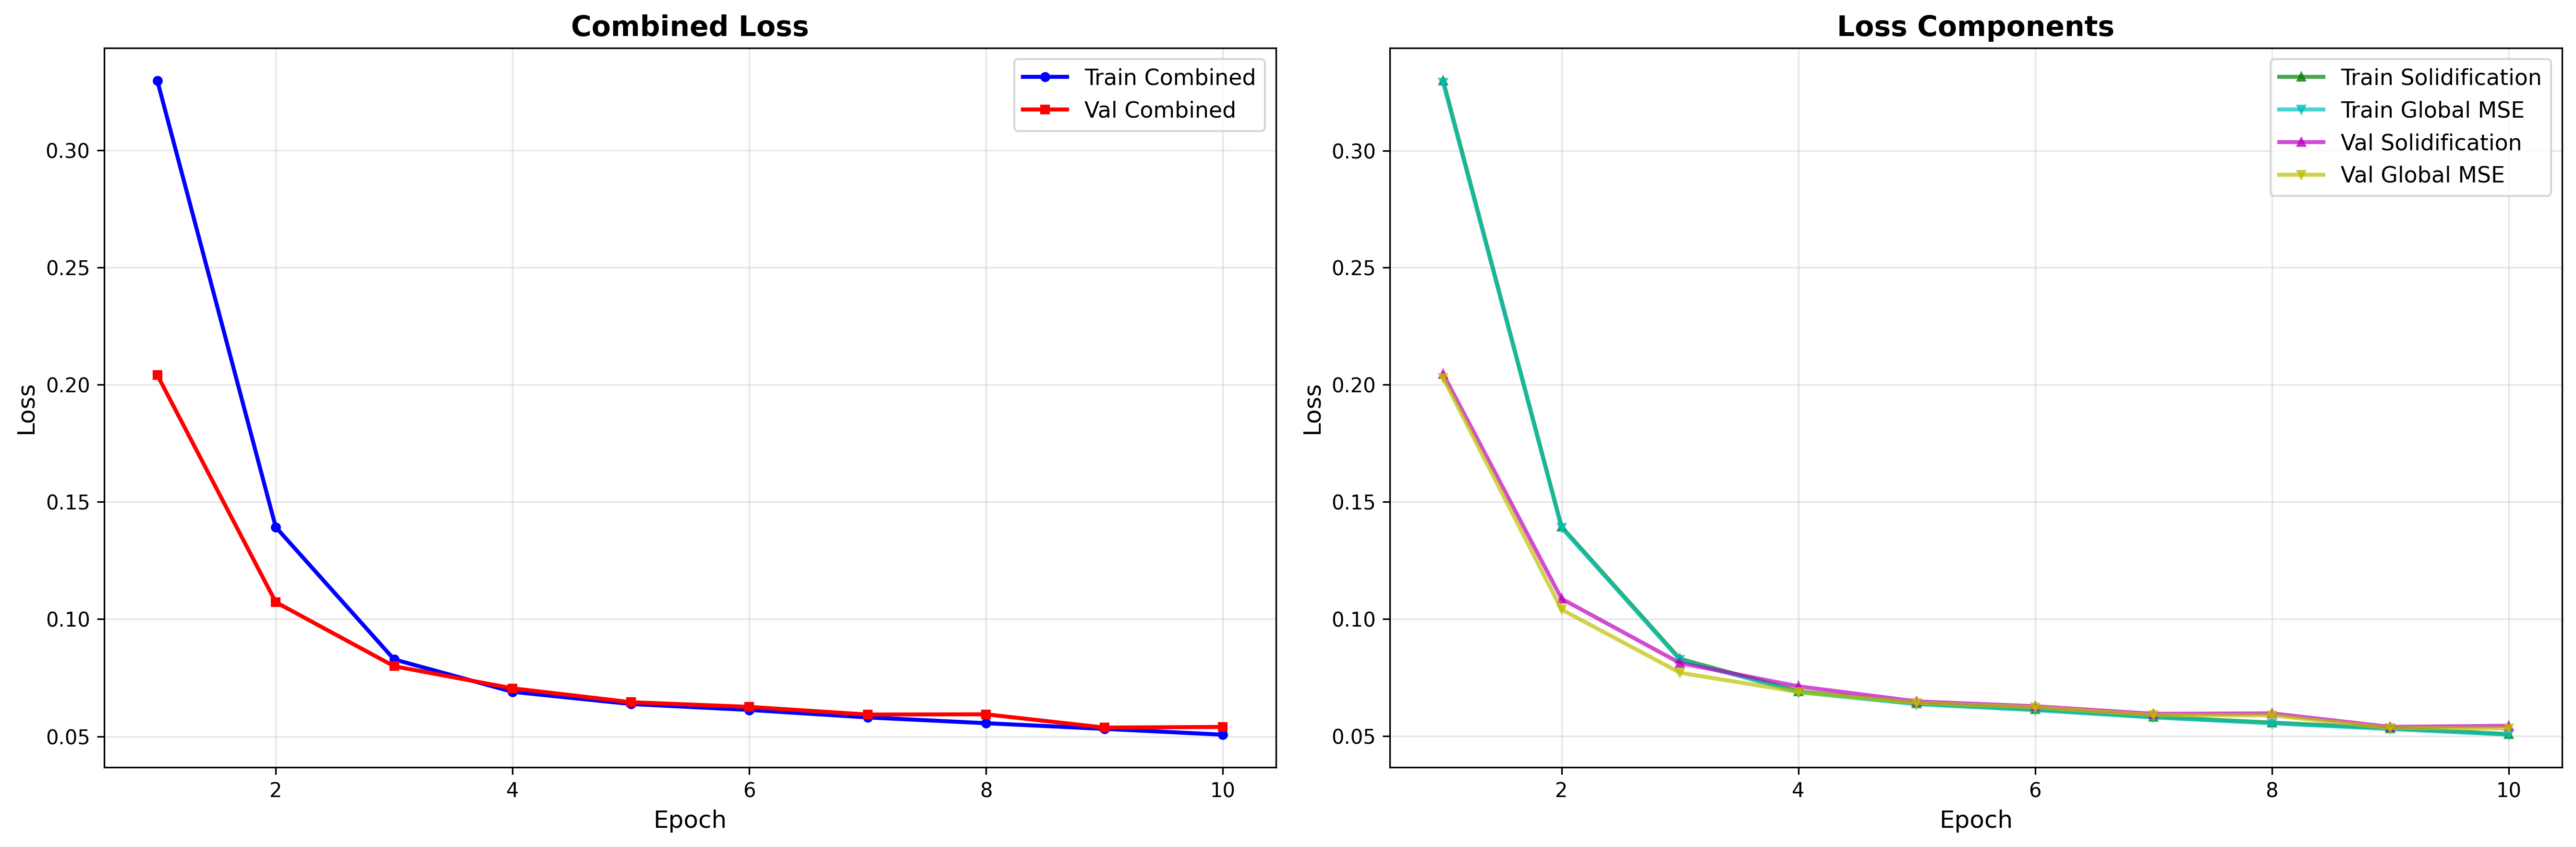

In [8]:
print("Training Loss Plots:\n")

for config in MODEL_CONFIGS:
    run_dir = OUTPUT_DIR / config['name']
    loss_plot_path = run_dir / "training_losses.png"

    if loss_plot_path.exists():
        print(f"\nModel {config['id']}: {config['name']}")
        display(Image(filename=str(loss_plot_path)))
    else:
        print(f"\nModel {config['id']}: No training losses plot found")

## Display Predictions

Display prediction visualizations for all models.

Prediction Visualizations (t=23, s=47):


Model 3: 3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620


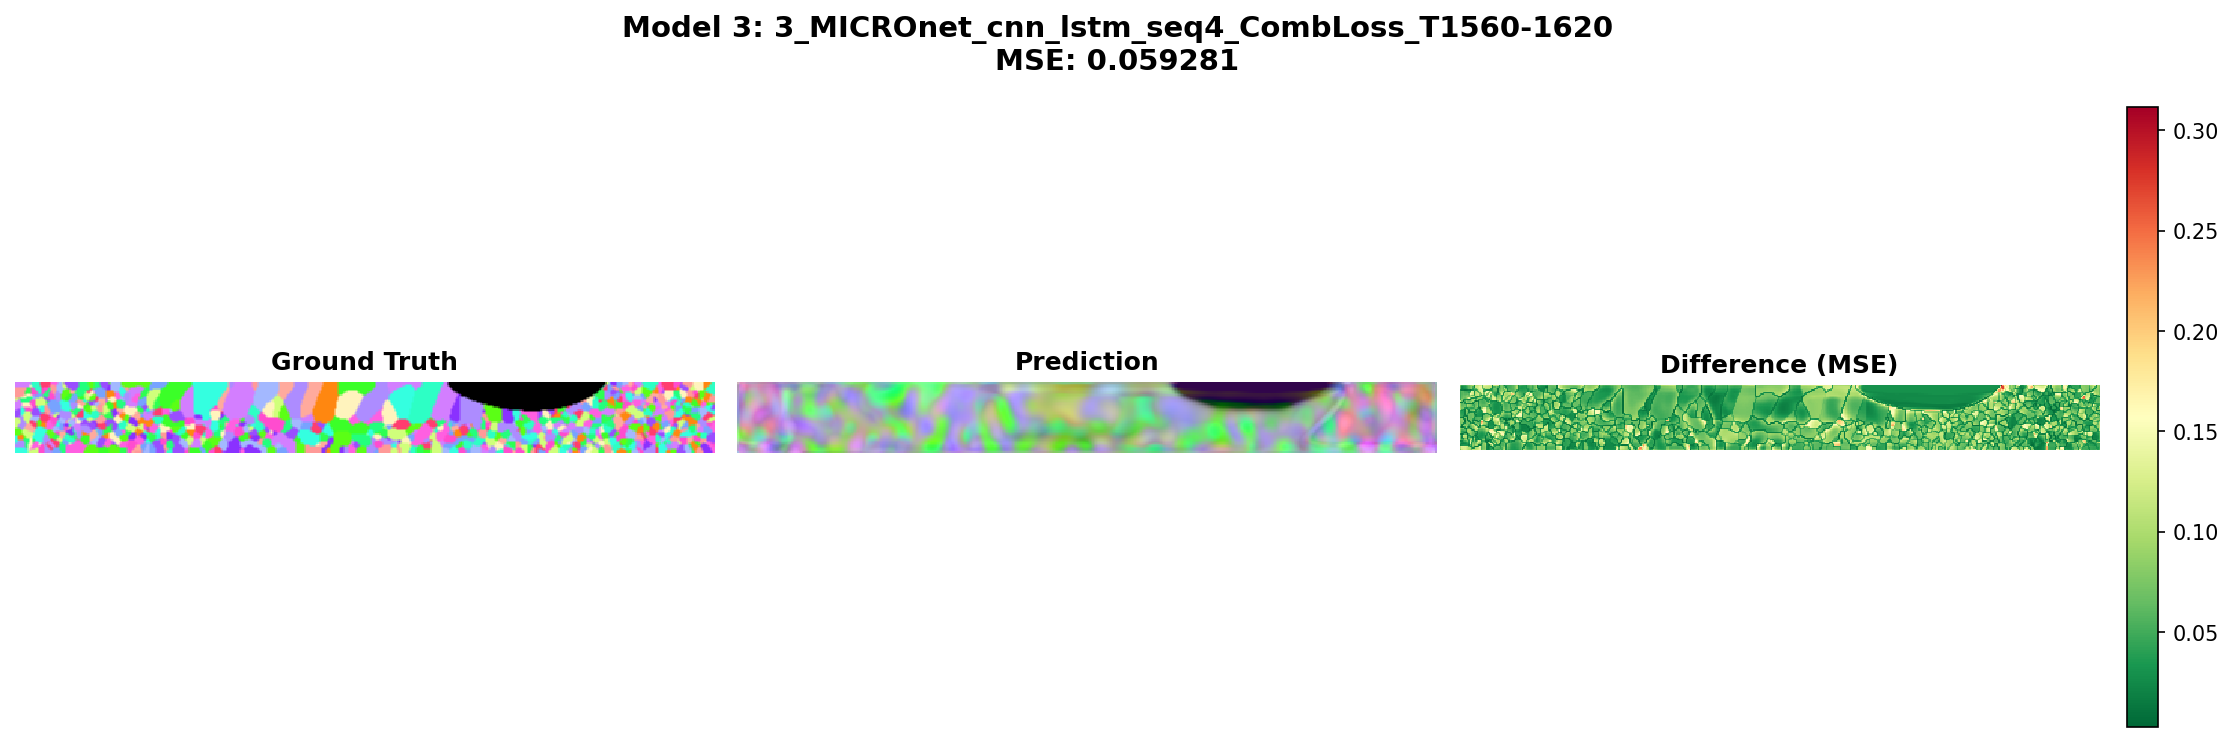

In [9]:
print(f"Prediction Visualizations (t={PRED_TIMESTEP}, s={PRED_SLICE}):\n")

for config in MODEL_CONFIGS:
    run_dir = OUTPUT_DIR / config['name']
    pred_path = run_dir / f"pred_t{PRED_TIMESTEP}_s{PRED_SLICE}.png"

    if pred_path.exists():
        print(f"\nModel {config['id']}: {config['name']}")
        display(Image(filename=str(pred_path)))
    else:
        print(f"\nModel {config['id']}: No prediction found")

## Display Solidification Mask Visualizations

Display solidification mask visualizations for models trained with combined loss.

Solidification Mask Visualizations (t=23, s=47):

(Only for models trained with combined loss)


Model 3: 3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620


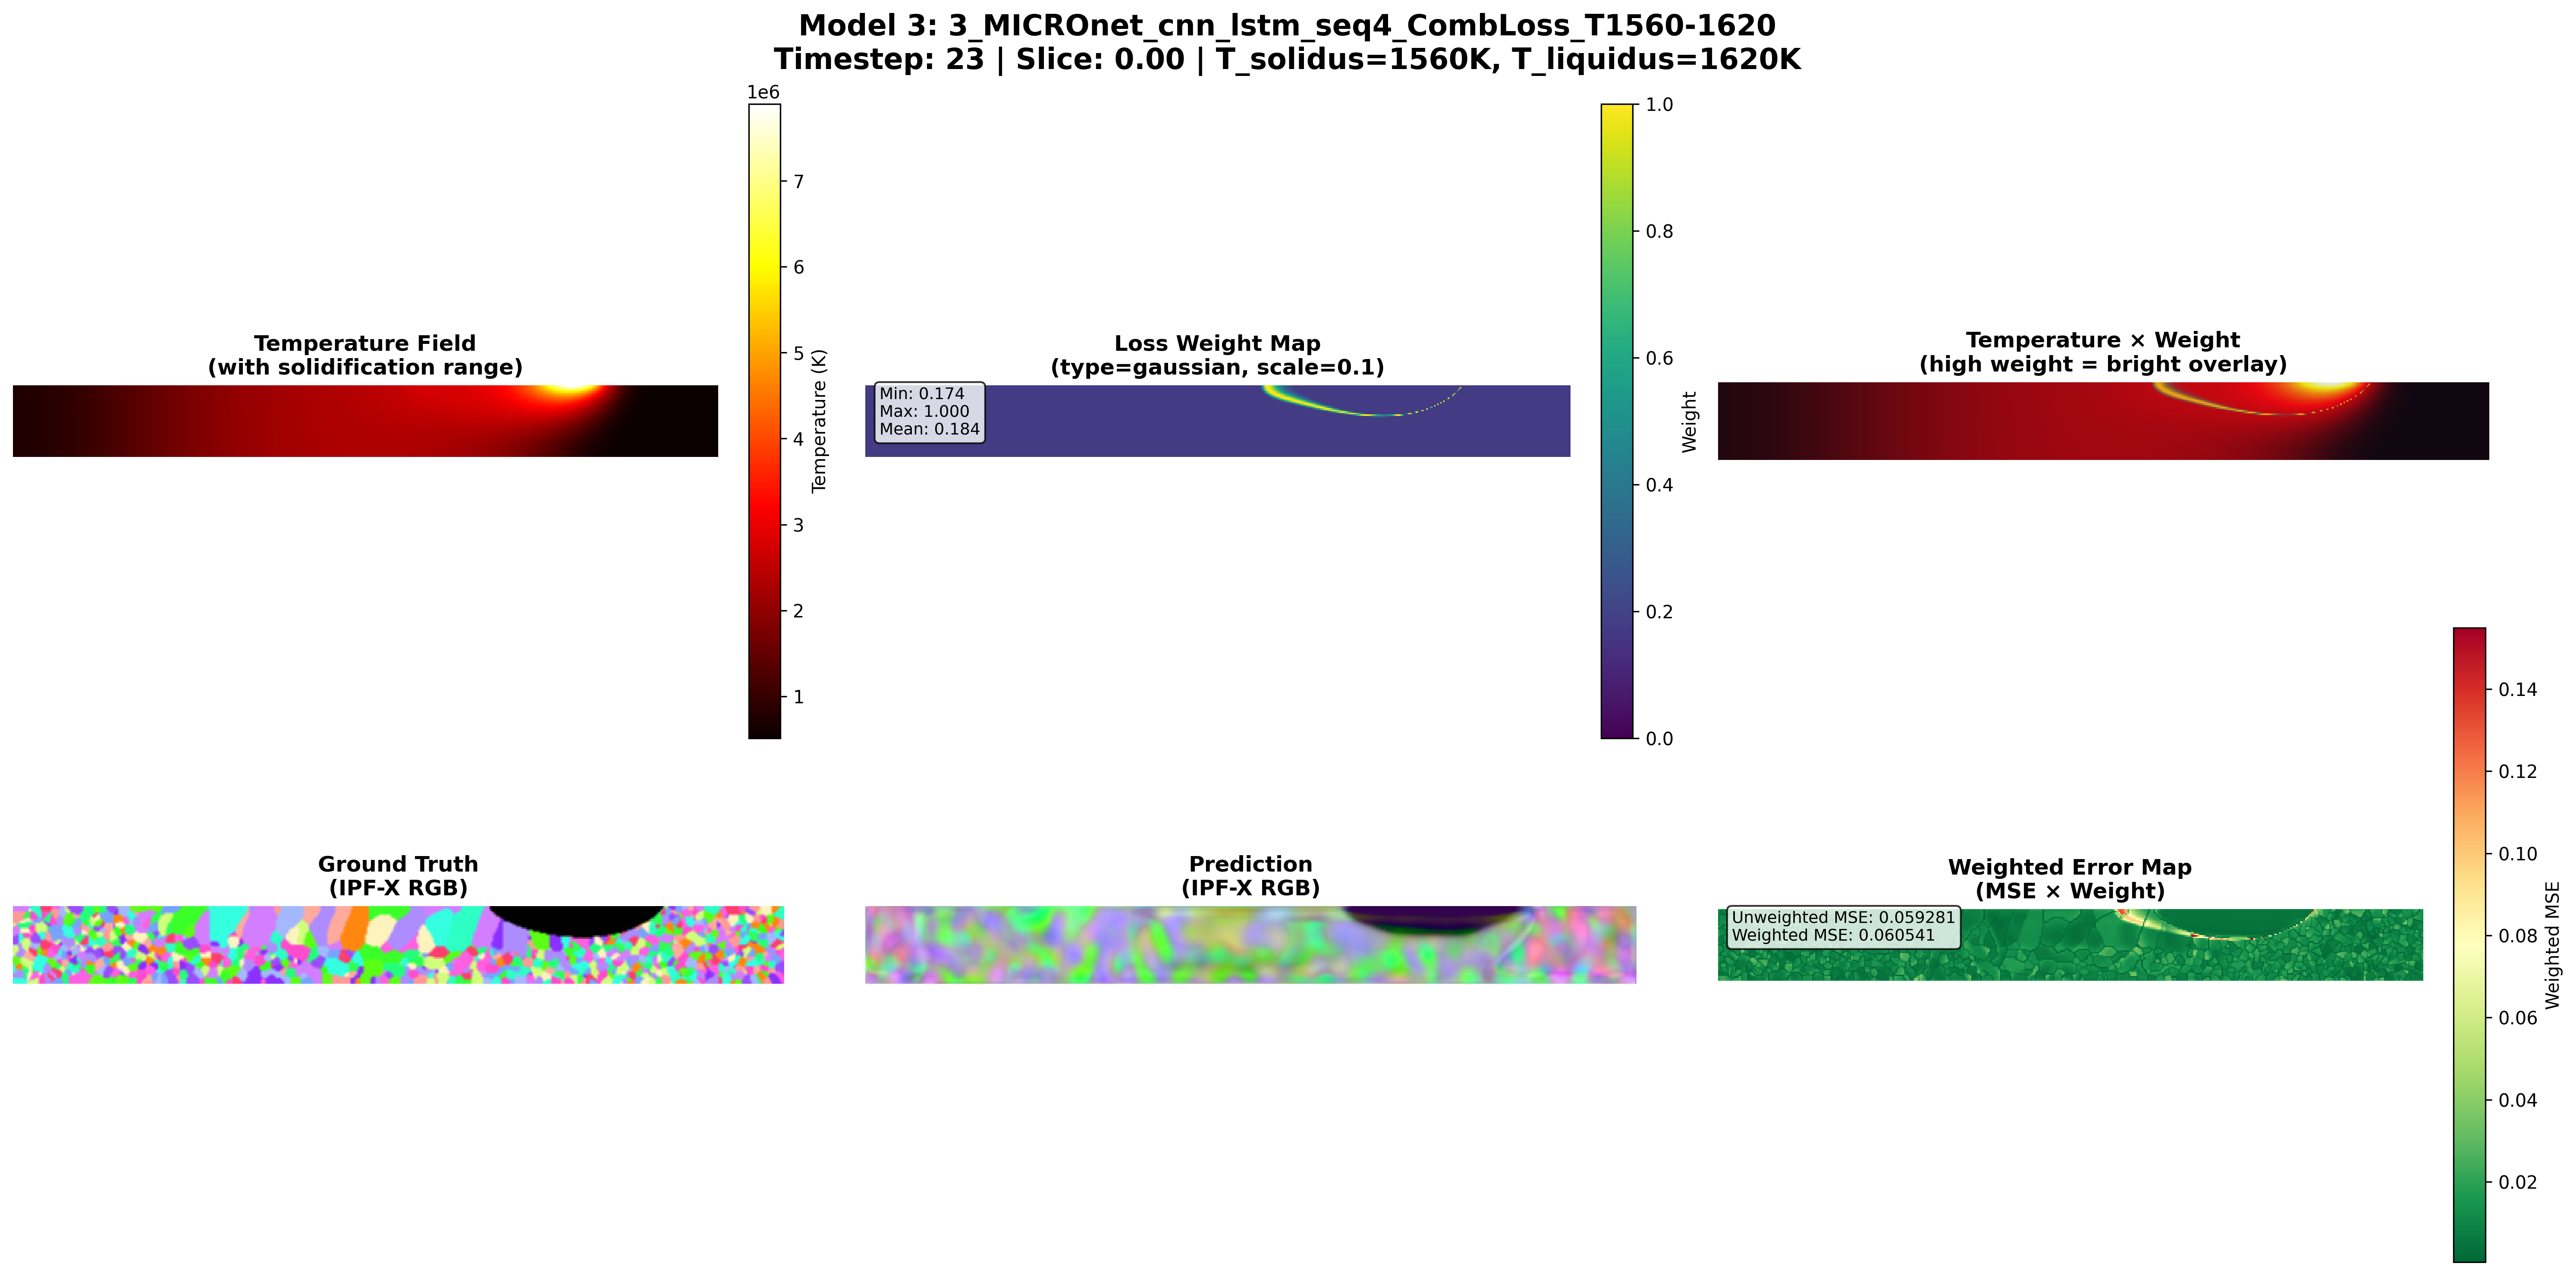

In [10]:
print(f"Solidification Mask Visualizations (t={PRED_TIMESTEP}, s={PRED_SLICE}):\n")
print("(Only for models trained with combined loss)\n")

for config in MODEL_CONFIGS:
    # Skip non-combined loss models
    if config['loss_type'] != 'combined':
        continue

    run_dir = OUTPUT_DIR / config['name']
    solid_mask_path = run_dir / f"solidification_mask_t{PRED_TIMESTEP}_s{PRED_SLICE}.png"

    if solid_mask_path.exists():
        print(f"\nModel {config['id']}: {config['name']}")
        display(Image(filename=str(solid_mask_path)))
    else:
        print(f"\nModel {config['id']}: No solidification mask found")

## Model Comparison

Compare training losses across all models.

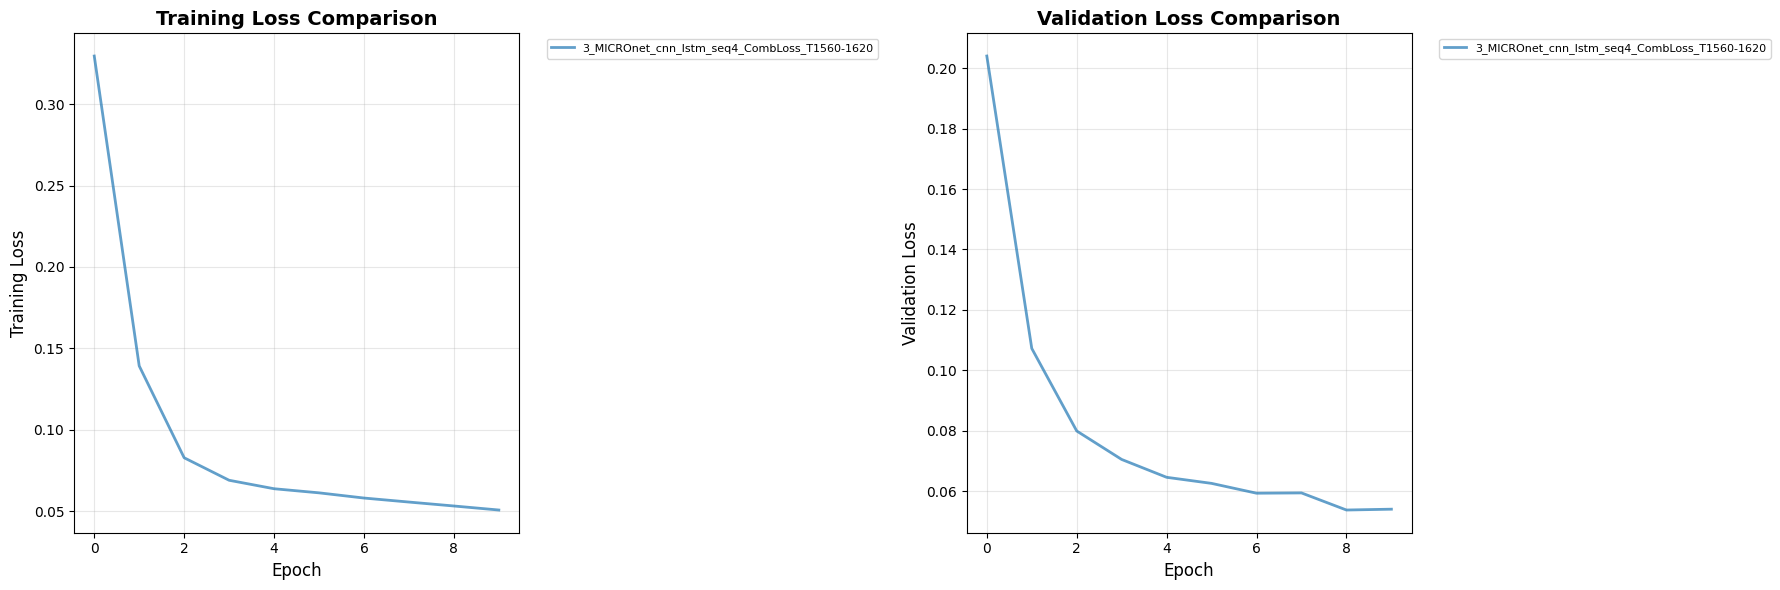


Comparison plot saved to MICROnet_output/all_models_comparison.png

MODEL COMPARISON SUMMARY
ID   Name                                               Final Train  Final Val    Epochs  
----------------------------------------------------------------------------------------------------
3    3_MICROnet_cnn_lstm_seq4_CombLoss_T1560-1620       0.050711     0.054011     10      


In [11]:
# Load all histories
histories = {}
for config in MODEL_CONFIGS:
    history_path = OUTPUT_DIR / config['name'] / "history.json"
    if history_path.exists():
        with open(history_path, 'r') as f:
            histories[config['name']] = json.load(f)

if histories:
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Training loss
    for name, history in histories.items():
        ax1.plot(history['train_loss'], label=name, linewidth=2, alpha=0.7)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Validation loss
    for name, history in histories.items():
        ax2.plot(history['val_loss'], label=name, linewidth=2, alpha=0.7)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Loss', fontsize=12)
    ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    comparison_path = OUTPUT_DIR / "all_models_comparison.png"
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nComparison plot saved to {comparison_path}")

    # Print summary table
    print("\n" + "="*100)
    print("MODEL COMPARISON SUMMARY")
    print("="*100)
    print(f"{'ID':<4} {'Name':<50} {'Final Train':<12} {'Final Val':<12} {'Epochs':<8}")
    print("-"*100)

    for config in MODEL_CONFIGS:
        name = config['name']
        if name in histories:
            history = histories[name]
            final_train = history['train_loss'][-1]
            final_val = history['val_loss'][-1]
            epochs = len(history['train_loss'])
            print(f"{config['id']:<4} {name:<50} {final_train:<12.6f} {final_val:<12.6f} {epochs:<8}")
        else:
            print(f"{config['id']:<4} {name:<50} {'N/A':<12} {'N/A':<12} {'N/A':<8}")

    print("="*100)
else:
    print("No training histories found.")

## Summary

All 10 models have been trained and evaluated!